In [4]:
import pandas as pd
import matplotlib as mpl
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math


import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [5]:
#df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')df = 
df = pd.read_csv('csv_session2.csv')

In [6]:
df

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,24/02/2016 15:53:00,NaN,NaN,85.0,72.0
1,24/02/2016 15:54:00,61441.0,61441.0,90.0,123.0
2,24/02/2016 15:55:00,153.0,51.0,91.0,153.0
3,24/02/2016 15:56:00,153.0,48.0,92.0,136.0
4,24/02/2016 15:57:00,153.0,46.0,NaN,NaN
...,...,...,...,...,...
6839,29/02/2016 09:52:00,NaN,NaN,NaN,NaN
6840,29/02/2016 09:53:00,NaN,NaN,NaN,NaN
6841,29/02/2016 09:54:00,NaN,NaN,NaN,NaN
6842,29/02/2016 09:55:00,NaN,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 0 to 6843
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Timestamp (GMT)             6844 non-null   object 
 1   Lifetouch Heart Rate        4388 non-null   float64
 2   Lifetouch Respiration Rate  4388 non-null   float64
 3   Oximeter SpO2               4352 non-null   float64
 4   Oximeter Pulse              4352 non-null   float64
dtypes: float64(4), object(1)
memory usage: 267.5+ KB


In [8]:
df['Timestamp (GMT)'] = pd.to_datetime(df['Timestamp (GMT)'], infer_datetime_format=True)

In [9]:
df = df.dropna()

In [10]:
df=  df.loc[df['Lifetouch Heart Rate'] <= 200]
df=  df.loc[df['Oximeter SpO2'] >= 40]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f223f53ea10>,
      dtype=object)

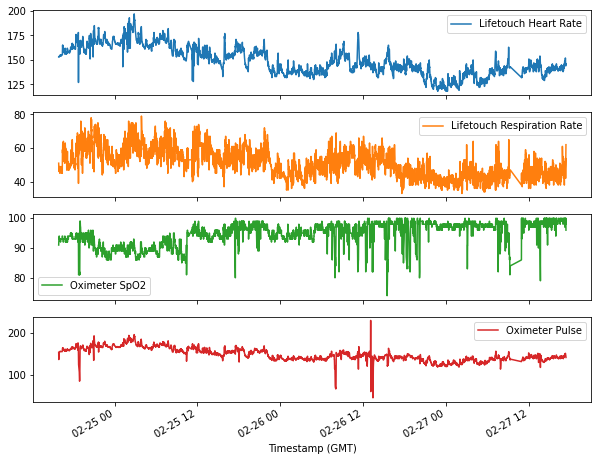

In [11]:
#df.set_index('date')[['Appliances', 'lights','T_out', 'RH_1', 'Visibility']].plot(subplots=True)
df.set_index('Timestamp (GMT)')[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate','Oximeter SpO2', 'Oximeter Pulse']].plot(subplots=True)

In [12]:
df_input=df[['Lifetouch Heart Rate', 'Lifetouch Respiration Rate','Oximeter SpO2', 'Oximeter Pulse']]

In [13]:
df_input

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
2,153.0,51.0,91.0,153.0
3,153.0,48.0,92.0,136.0
6,153.0,46.0,94.0,153.0
7,153.0,49.0,94.0,154.0
8,154.0,48.0,93.0,154.0
...,...,...,...,...
4406,149.0,54.0,100.0,149.0
4407,147.0,42.0,99.0,147.0
4408,144.0,53.0,98.0,146.0
4409,144.0,57.0,100.0,145.0


In [14]:
df_input.describe()

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
count,4074.000000,4074.000000,4074.000000,4074.000000
mean,148.998773,51.338488,94.647275,147.913844
std,14.771199,8.394903,3.919336,16.057492
min,118.000000,33.000000,74.000000,44.000000
25%,138.000000,45.000000,93.000000,137.000000
50%,146.000000,51.000000,96.000000,145.000000
75%,161.000000,57.000000,98.000000,160.000000
max,197.000000,79.000000,100.000000,230.000000


In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_input)

In [16]:
data_scaled

array([[0.44303797, 0.39130435, 0.65384615, 0.58602151],
       [0.44303797, 0.32608696, 0.69230769, 0.49462366],
       [0.44303797, 0.2826087 , 0.76923077, 0.58602151],
       ...,
       [0.32911392, 0.43478261, 0.92307692, 0.5483871 ],
       [0.32911392, 0.52173913, 1.        , 0.54301075],
       [0.35443038, 0.63043478, 0.84615385, 0.52150538]])

In [17]:
features=data_scaled
target=data_scaled[:,0]

In [18]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.44303797, 0.39130435, 0.65384615, 0.58602151],
         [0.44303797, 0.32608696, 0.69230769, 0.49462366]]]),
 array([0.44303797]))

In [19]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)

In [20]:
x_train.shape

(3259, 4)

In [21]:
x_test.shape

(815, 4)

In [22]:
win_length=500
batch_size=11
num_features=4
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [23]:
train_generator[0]

(array([[[0.44303797, 0.39130435, 0.65384615, 0.58602151],
         [0.44303797, 0.32608696, 0.69230769, 0.49462366],
         [0.44303797, 0.2826087 , 0.76923077, 0.58602151],
         ...,
         [0.60759494, 0.45652174, 0.65384615, 0.65591398],
         [0.60759494, 0.36956522, 0.61538462, 0.66129032],
         [0.62025316, 0.39130435, 0.61538462, 0.66129032]],
 
        [[0.44303797, 0.32608696, 0.69230769, 0.49462366],
         [0.44303797, 0.2826087 , 0.76923077, 0.58602151],
         [0.44303797, 0.34782609, 0.76923077, 0.59139785],
         ...,
         [0.60759494, 0.36956522, 0.61538462, 0.66129032],
         [0.62025316, 0.39130435, 0.61538462, 0.66129032],
         [0.60759494, 0.36956522, 0.61538462, 0.66129032]],
 
        [[0.44303797, 0.2826087 , 0.76923077, 0.58602151],
         [0.44303797, 0.34782609, 0.76923077, 0.59139785],
         [0.4556962 , 0.32608696, 0.73076923, 0.59139785],
         ...,
         [0.62025316, 0.39130435, 0.61538462, 0.66129032],
        

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.9)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.9)) 
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mse', optimizer='adam')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 128)          68096     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 500, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 500, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 199,809
Trainable params: 199,809
Non-trainable params: 0
__________________________________________________

In [81]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])



Epoch 1/50
251/251 [==============================] - 202s 792ms/step - loss: 0.0092 - mean_absolute_error: 0.0732 - val_loss: 0.0017 - val_mean_absolute_error: 0.0321
Epoch 2/50
251/251 [==============================] - 198s 790ms/step - loss: 0.0106 - mean_absolute_error: 0.0774 - val_loss: 0.0019 - val_mean_absolute_error: 0.0348
Epoch 3/50
251/251 [==============================] - 197s 787ms/step - loss: 0.0107 - mean_absolute_error: 0.0772 - val_loss: 0.0017 - val_mean_absolute_error: 0.0323


In [45]:
model.evaluate_generator(test_generator, verbose=0)  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0015603344654664397, 0.030940238386392593]

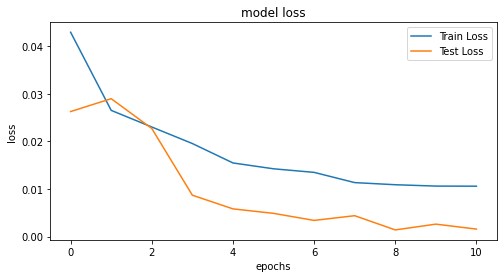

In [64]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [65]:
predictions=model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [66]:
predictions.shape[0]

315

In [67]:
predictions

array([[0.31881344],
       [0.31543332],
       [0.30541635],
       [0.29310194],
       [0.28108755],
       [0.270944  ],
       [0.2660521 ],
       [0.26298228],
       [0.2659354 ],
       [0.2724735 ],
       [0.2796051 ],
       [0.28781447],
       [0.29452604],
       [0.3025711 ],
       [0.31113407],
       [0.3167734 ],
       [0.3181499 ],
       [0.31775707],
       [0.3157339 ],
       [0.3122779 ],
       [0.30856192],
       [0.30670565],
       [0.30556047],
       [0.30293462],
       [0.30056685],
       [0.29765332],
       [0.29560578],
       [0.29296172],
       [0.29203594],
       [0.29022157],
       [0.2900492 ],
       [0.28907025],
       [0.29050213],
       [0.29252788],
       [0.29523602],
       [0.29334596],
       [0.28714517],
       [0.27937162],
       [0.27215052],
       [0.2681644 ],
       [0.2697305 ],
       [0.27745837],
       [0.27910954],
       [0.27709618],
       [0.27476716],
       [0.2738938 ],
       [0.27370286],
       [0.276

In [68]:
y_test

array([0.12658228, 0.07594937, 0.08860759, 0.12658228, 0.08860759,
       0.10126582, 0.13924051, 0.11392405, 0.11392405, 0.11392405,
       0.07594937, 0.05063291, 0.08860759, 0.06329114, 0.10126582,
       0.10126582, 0.07594937, 0.07594937, 0.05063291, 0.03797468,
       0.06329114, 0.06329114, 0.06329114, 0.05063291, 0.03797468,
       0.06329114, 0.03797468, 0.06329114, 0.02531646, 0.03797468,
       0.03797468, 0.03797468, 0.02531646, 0.01265823, 0.01265823,
       0.01265823, 0.07594937, 0.10126582, 0.11392405, 0.26582278,
       0.2278481 , 0.17721519, 0.2278481 , 0.18987342, 0.10126582,
       0.08860759, 0.11392405, 0.10126582, 0.10126582, 0.11392405,
       0.07594937, 0.11392405, 0.10126582, 0.11392405, 0.08860759,
       0.10126582, 0.08860759, 0.11392405, 0.13924051, 0.12658228,
       0.10126582, 0.10126582, 0.10126582, 0.10126582, 0.11392405,
       0.15189873, 0.21518987, 0.20253165, 0.2278481 , 0.20253165,
       0.18987342, 0.15189873, 0.17721519, 0.20253165, 0.24050

In [69]:
x_test

array([[0.12658228, 0.17391304, 0.88461538, 0.4516129 ],
       [0.07594937, 0.13043478, 0.88461538, 0.44623656],
       [0.08860759, 0.10869565, 0.92307692, 0.44086022],
       ...,
       [0.32911392, 0.43478261, 0.92307692, 0.5483871 ],
       [0.32911392, 0.52173913, 1.        , 0.54301075],
       [0.35443038, 0.63043478, 0.84615385, 0.52150538]])

In [70]:
x_test[:,1:][win_length:]

array([[0.26086957, 0.92307692, 0.51612903],
       [0.34782609, 0.96153846, 0.51075269],
       [0.19565217, 0.96153846, 0.51075269],
       [0.26086957, 0.92307692, 0.50537634],
       [0.19565217, 0.92307692, 0.51075269],
       [0.30434783, 0.92307692, 0.51075269],
       [0.30434783, 0.96153846, 0.52150538],
       [0.2826087 , 0.92307692, 0.53763441],
       [0.32608696, 0.88461538, 0.53225806],
       [0.19565217, 0.92307692, 0.5483871 ],
       [0.34782609, 0.92307692, 0.54301075],
       [0.06521739, 0.92307692, 0.54301075],
       [0.2173913 , 0.92307692, 0.5483871 ],
       [0.23913043, 0.96153846, 0.5483871 ],
       [0.23913043, 0.92307692, 0.5483871 ],
       [0.26086957, 0.92307692, 0.53763441],
       [0.30434783, 0.88461538, 0.54301075],
       [0.13043478, 0.92307692, 0.5483871 ],
       [0.32608696, 0.92307692, 0.53225806],
       [0.2826087 , 0.92307692, 0.55913978],
       [0.13043478, 0.92307692, 0.54301075],
       [0.26086957, 0.92307692, 0.54301075],
       [0.

In [71]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [72]:
df_pred

,0,0,1,2
0,0.318813,0.260870,0.923077,0.516129
1,0.315433,0.347826,0.961538,0.510753
2,0.305416,0.195652,0.961538,0.510753
3,0.293102,0.260870,0.923077,0.505376
4,0.281088,0.195652,0.923077,0.510753
...,...,...,...,...
310,0.317335,0.456522,1.000000,0.564516
311,0.318430,0.195652,0.961538,0.553763
312,0.317483,0.434783,0.923077,0.548387
313,0.313632,0.521739,1.000000,0.543011


In [73]:
rev_trans=scaler.inverse_transform(df_pred)

In [74]:
rev_trans

array([[143.18626201,  45.        ,  98.        , 140.        ],
       [142.91923255,  49.        ,  99.        , 139.        ],
       [142.1278913 ,  42.        ,  99.        , 139.        ],
       ...,
       [143.08112702,  53.        ,  98.        , 146.        ],
       [142.77689594,  57.        , 100.        , 145.        ],
       [142.22102129,  62.        ,  96.        , 141.        ]])

In [75]:
df_final=df_input[predictions.shape[0]*-1:]

In [76]:
df_final.count()

Lifetouch Heart Rate          315
Lifetouch Respiration Rate    315
Oximeter SpO2                 315
Oximeter Pulse                315
dtype: int64

In [77]:
df_final['Predicted Heart Rate']=rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
df_final

,Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,Predicted Heart Rate
4091,142.0,45.0,98.0,140.0,143.186262
4092,139.0,49.0,99.0,139.0,142.919233
4093,139.0,42.0,99.0,139.0,142.127891
4094,138.0,45.0,98.0,138.0,141.155053
4095,138.0,42.0,98.0,139.0,140.205916
...,...,...,...,...,...
4406,149.0,54.0,100.0,149.0,143.069468
4407,147.0,42.0,99.0,147.0,143.156006
4408,144.0,53.0,98.0,146.0,143.081127
4409,144.0,57.0,100.0,145.0,142.776896


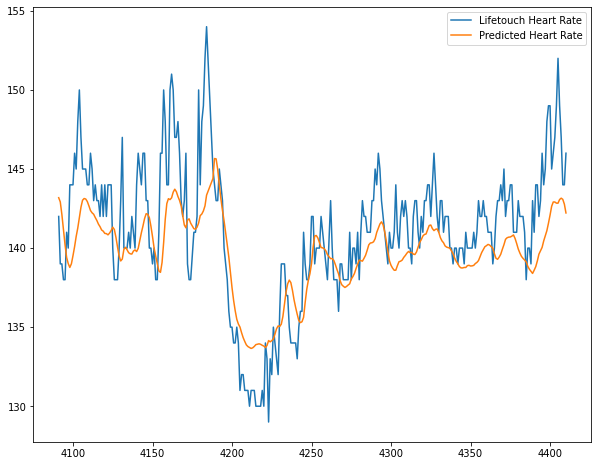

In [79]:
df_final[['Lifetouch Heart Rate','Predicted Heart Rate']].plot()

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt
expected = df_final['Lifetouch Heart Rate']
predictions = df_final['Predicted Heart Rate']
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 3.120585
